In [6]:
import os 

from langchain_community.tools import ArxivQueryRun,WikipediaQueryRun
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper


In [10]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [13]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [15]:
api_wrapper_wiki= WikipediaAPIWrapper(top_k_results=1,doc_content_chars_max=250)
wiki= WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [16]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ['TAVILY_API_KEY']=os.getenv("TAVILY_API_KEY")
os.environ['GROQ_API_KEY']=os.getenv("GROQ_API_KEY")

In [17]:
from langchain.tools.tavily_search import TavilySearchResults
tavily=TavilySearchResults()

In [18]:
tavily.invoke("Who won RCB VS LSG MATCH IN 2025?")

[{'title': 'Blog: Jitesh 85* off 33 takes RCB into Qualifer 1 - ESPNcricinfo',
  'url': 'https://www.espncricinfo.com/series/ipl-2025-1449924/lucknow-super-giants-vs-royal-challengers-bengaluru-70th-match-1473507/live-match-blog',
  'content': "Edition US\nRESULT\n70th Match (N), Lucknow, May 27, 2025, Indian Premier League\nPrevNext\nLSG\n7\n227/3\nRCB\n2\n(18.4/20 ov, T:228) 230/4\nRCB won by 6 wickets (with 8 balls remaining)\nPlayer Of The Match\nJitesh Sharma\n, RCB\n85* (33)\n \nCricinfo's MVP\nJitesh Sharma\n, RCB\n114.63 ptsImpact List\n \nSummary\nScorecard\nMVP\nReport\nCommentary\nStats\nOvers\nTable\nBlog\nNews\nVideos\nPhotos\nFan Ratings\nTimeline\nShowing newest first\n*   20h ago RCB through to Qualifier 1 [...] The ball seemed to be swinging but Jitesh, instead of going for Bhuvneshwar Kumar, gave the second over to Krunal Pandya. On his third ball, Breetzke cleared his front leg and launched him over long-on.\nLSG 21/0 after two\n3\n1\n1\n1\n27 May 2025, 1:51 pm\nRCB'

In [19]:
tools=[arxiv,wiki,tavily]

In [22]:
from langchain_groq import ChatGroq

llm=ChatGroq(model='Qwen-Qwq-32b')
llm_with_tools=llm.bind_tools(tools)

In [26]:
from langchain_core.messages import HumanMessage, AIMessage
from pprint import pprint
llm_with_tools.invoke([HumanMessage(content="What is the latest tech news about AI?")])

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_04he', 'function': {'arguments': '{"query":"latest tech news about AI"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 197, 'prompt_tokens': 404, 'total_tokens': 601, 'completion_time': 0.458907545, 'prompt_time': 0.039480694, 'queue_time': 0.265241766, 'total_time': 0.498388239}, 'model_name': 'Qwen-Qwq-32b', 'system_fingerprint': 'fp_28178d7ff6', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--f92b5a64-d6f5-490e-a42a-3358809f8ae0-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'latest tech news about AI'}, 'id': 'call_04he', 'type': 'tool_call'}], usage_metadata={'input_tokens': 404, 'output_tokens': 197, 'total_tokens': 601})

NameError: name 'State' is not defined

In [31]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

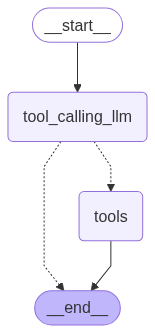

In [32]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

### Node definition
def tool_calling_llm(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)


graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [33]:
messages=graph.invoke({"messages":HumanMessage(content="1706.03762")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

1706.03762
================================== Ai Message ==================================
Tool Calls:
  arxiv (call_7n0c)
 Call ID: call_7n0c
  Args:
    query: 1706.03762
================================= Tool Message =================================
Name: arxiv

Published: 2023-08-02
Title: Attention Is All You Need
Authors: Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N. Gomez, Lukasz Kaiser, Illia Polosukhin
Summary: The dominant sequence transduction models are based on complex recurrent or
convolutional neural networks in an encoder-decoder configuration. The best
performing models also connect the encoder and decoder through an attention
mechanism. We propose a new simple network architecture, the Transformer, base
